In [48]:
import os
import json
import math

# ! pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn

from tqdm import tqdm
import glob

from PIL import Image
from sklearn.metrics import f1_score

from skimage import morphology, color

import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, random_split
from torchvision.transforms import transforms
from torchvision.transforms.functional import pad, to_pil_image, to_tensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from transformers import (TrOCRProcessor, 
                        TrOCRForCausalLM, 
                        VisionEncoderDecoderModel, 
                        ViTFeatureExtractor, 
                        ViTForImageClassification)

from utils.utils import *

In [3]:
dataset_path = "data/all_preprocessed_data/"

# Create a custom ToRGB transform
class ToRGB(object):
    def __call__(self, image):
        return image.convert('RGB')

# Transforms pipeline for train and validation data loaders
preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
    ToRGB(),
#   (erosion followed by !dilation is operated on the grayscale image)
#     PartialErosion(iterations=2),
#     transforms.ToTensor(),

#     transforms.Grayscale(num_output_channels=3),
#     transforms.Grayscale(),
#     transforms.Normalize([0.5], [0.5])
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     transforms.ToPILImage()
])

# Load the entire dataset (since we don't have a train and validation split in the )
# dataset = ImageFolder(dataset_path, transform=preprocess)

In [32]:
# Initialize the model and processor
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-stage1')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-stage1')

# processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Freeze TrOCR layers
for param in model.parameters():
    param.requires_grad = False

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Define our classifier
classifier = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, kernel_size=1, stride=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * (577 // 8) * (1024 // 8), 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
#     nn.Dropout(0.2),
    nn.ReLU(inplace=True),
    nn.Linear(256, 1)
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.003)

classifier

Sequential(
  (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=294912, out_features=512, bias=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=512, out_features=512, bias=True)
  (13): ReLU(inplace=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU(inplace=True)
  (17): Linear(in_features=256, out_features=1, bias=True)
)

In [6]:
# Move the model to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [25]:
dataset = TrOCRPreprocessor(dataset_path, processor)

In [26]:
# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# Create the DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_size, val_size

(357104, 89276)

In [33]:
# If there are multiple GPUs available, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, list(range(torch.cuda.device_count())))

model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): VisionEncoderDecoderModel(
    (encoder): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=False)
                (key): Linear(in_features=1024, out_features=1024, bias=False)
                (value): Linear(in_features=1024, out_features=1024, bias=False)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
      

In [21]:
# # Loop to extract image representation (using the TrOCR encoder) and store the tensors 

# num_epochs = 1

# # (this step is one-time as we are not training the TrOCR model)
# for epoch in range(num_epochs):
    
#     with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
#         for batch_idx, (pixel_values, labels) in pbar:
#             pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)
                        
#             # The `encoder_outputs` variable will contain the intermediate output 
#             # of the vision transformer part of the TrOCR model
#             encoder_outputs = model.module.encoder(pixel_values)

#             # This is the image representation
#             image_representation = encoder_outputs.last_hidden_state
#             # print(image_representation.shape)
#             # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 1, 1024, ]
#             torch.save(image_representation.cpu(), f'tensors/train/train_image_representation_{epoch}_{batch_idx}.pt')
#             torch.save(labels.cpu(), f'tensors/train/labels_{epoch}_{batch_idx}.pt')
    
#     with torch.no_grad():
#         with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

#             for batch_idx, (pixel_values, labels) in pbar:
#                 pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

#                 # The `encoder_outputs` variable will contain the intermediate output 
#                 # of the vision transformer part of the TrOCR model
#                 encoder_outputs = model.module.encoder(pixel_values)

#                 # This is the image representation
#                 image_representation = encoder_outputs.last_hidden_state
#                 # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
#                 torch.save(image_representation.cpu(), f'tensors/valid/val_image_representation_{epoch}_{batch_idx}.pt')
#                 torch.save(labels.cpu(), f'tensors/valid/labels_{epoch}_{batch_idx}.pt')

100%|██████████| 2790/2790 [1:15:25<00:00,  1.62s/it]


In [40]:
# TensorBoard setup
from torch.utils.tensorboard import SummaryWriter
import torchvision

writer = SummaryWriter("logs/trocr_encoder_w_classifier/") # this will create a folder if there isn't one

# get some random training images
# dummy_preprocess = transforms.Compose([
#     transforms.Resize([384, 384]),
#     transforms.ToTensor()
# ])

# dummy_dataset = ImageFolder(dataset_path, transform=dummy_preprocess)
# dummy_loader = DataLoader(dummy_dataset, batch_size=4)
dataiter = iter(train_loader)
images, labels = next(dataiter)

images, labels = images.squeeze(1).to(device), labels.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)
writer.add_image("Sample training images", img_grid)


class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input):
        output = self.model(input)
        # Convert the dictionary output to a tuple.
        return tuple(output.values())

# Visualize the classifier we created
writer.add_graph(ModelWrapper(model.module.encoder), images)

In [39]:
train_tensor_directory = 'tensors/train'
train_dataset = TensorDataset(train_tensor_directory)
train_loader_tensor = DataLoader(train_dataset, batch_size=1, shuffle=False)

val_tensor_directory = 'tensors/valid'
val_dataset = TensorDataset(val_tensor_directory)
val_loader_tensor = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [45]:
num_epochs = 20
best_val_loss = float('inf')
counter = 0

patience = 5

classifier = torch.nn.DataParallel(classifier, [0]) # list(range(torch.cuda.device_count()))
classifier = classifier.to(device)

writer = SummaryWriter("logs/trocr_encoder_w_classifier_exp_1/")

# Training loop
classifier.train()
for epoch in range(num_epochs):
    
    val_correct = 0
    train_correct = 0
    
    val_loss = 0
    train_loss = 0
    
    with tqdm(enumerate(train_loader_tensor), total=math.ceil(train_size/batch_size)) as pbar:
        
        for batch_idx, (image_representation, labels) in pbar:
            
            image_representation = image_representation.squeeze(0).unsqueeze(1)
            labels = labels.float().squeeze(0)
            image_representation, labels = image_representation.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # Pass the image features through the classifier
            classifier_output = classifier(image_representation)
            loss = loss_function(classifier_output, labels)
            
            predictions = torch.round(torch.sigmoid(classifier_output))

            train_loss += loss.item()
            train_correct += (predictions == labels).sum().item()

            loss.backward()
            optimizer.step()
    
    
    classifier.eval()
    with torch.no_grad():
        with tqdm(enumerate(val_loader_tensor), total=math.ceil(val_size/batch_size)) as pbar:

            for batch_idx, (image_representation, labels) in pbar:
                
                image_representation = image_representation.squeeze(0).unsqueeze(1)
                labels = labels.float().squeeze(0)
                image_representation, labels = image_representation.to(device), labels.to(device)

                # Pass the image features through the classifier
                classifier_output = classifier(image_representation)
                loss = loss_function(classifier_output, labels)

                predictions = torch.round(torch.sigmoid(classifier_output))

                val_loss += loss.item()
                val_correct += (predictions == labels).sum().item()
    
    # Calculate average loss and accuracy
    train_loss /= train_size
    train_accuracy = train_correct / train_size

    val_loss /= val_size
    val_accuracy = val_correct / val_size
    
    writer.add_scalars("Loss tracking", {"train_loss": train_loss, "val_loss": val_loss}, epoch+1)
    writer.add_scalars("Accuracy tracking", {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}, epoch+1)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )
    
    # Save the best model based on validation loss and early stopping
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the model
        print("Saving model...")
        torch.save(classifier.state_dict(), 'model/TrOCR_L_enc_feature_extraction_w_classifier.pth')
    else:
        counter += 1
        # Check if the counter reaches the patience limit
        if counter >= patience:
            print('Early stopping triggered...')
            break

100%|██████████| 2790/2790 [13:29<00:00,  3.45it/s]


Epoch [1/20], 
Train Loss: 0.0002, Train Accuracy: 0.9980, 
Val Loss: 0.0003, Val Accuracy: 0.9986 

Saving model...


100%|██████████| 2790/2790 [13:35<00:00,  3.42it/s]


Epoch [2/20], 
Train Loss: 0.0002, Train Accuracy: 0.9986, 
Val Loss: 0.0003, Val Accuracy: 0.9986 



100%|██████████| 2790/2790 [13:34<00:00,  3.43it/s]


Epoch [3/20], 
Train Loss: 0.0001, Train Accuracy: 0.9989, 
Val Loss: 0.0004, Val Accuracy: 0.9983 



100%|██████████| 2790/2790 [13:39<00:00,  3.40it/s]


Epoch [4/20], 
Train Loss: 0.0001, Train Accuracy: 0.9992, 
Val Loss: 0.0006, Val Accuracy: 0.9976 



100%|██████████| 2790/2790 [12:57<00:00,  3.59it/s]


Epoch [5/20], 
Train Loss: 0.0001, Train Accuracy: 0.9991, 
Val Loss: 0.0005, Val Accuracy: 0.9980 



 38%|███▊      | 4292/11160 [20:04<31:26,  3.64it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# num_epochs = 15
# best_val_loss = float('inf')
# counter = 0

# patience = 5

# # Training loop
# for epoch in range(num_epochs):
    
#     val_correct = 0
#     train_correct = 0
    
#     val_loss = 0
#     train_loss = 0
    
#     with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:
        
#         for batch_idx, (pixel_values, labels) in pbar:
#             pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)
                        
#             # The `encoder_outputs` variable will contain the intermediate output 
#             # of the vision transformer part of the TrOCR model
#             encoder_outputs = model.encoder(pixel_values)

#             # This is the image representation
#             image_representation = encoder_outputs.last_hidden_state
#             # print(image_representation.shape)
#             # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]
            
#             optimizer.zero_grad()
#             # Pass the image features through the classifier
#             classifier_output = classifier(image_representation.unsqueeze(1))
#             loss = loss_function(classifier_output, labels)
            
#             predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

#             train_loss += loss.item()
#             train_correct += (predictions == labels).sum().item()

#             loss.backward()
#             optimizer.step()
    
    
#     classifier.eval()
#     with torch.no_grad():
#         with tqdm(enumerate(val_loader), total=math.ceil(val_size/batch_size)) as pbar:

#             for batch_idx, (pixel_values, labels) in pbar:
#                 pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

#                 # The `encoder_outputs` variable will contain the intermediate output 
#                 # of the vision transformer part of the TrOCR model
#                 encoder_outputs = model.encoder(pixel_values)

#                 # This is the image representation
#                 image_representation = encoder_outputs.last_hidden_state
#                 # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]

#                 # Pass the image features through the classifier
#                 classifier_output = classifier(image_representation.unsqueeze(1))
#                 loss = loss_function(classifier_output, labels)

#                 predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

#                 val_loss += loss.item()
#                 val_correct += (predictions == labels).sum().item()
    
#     # Calculate average loss and accuracy
#     train_loss /= train_size
#     train_accuracy = train_correct / train_size

#     val_loss /= val_size
#     val_accuracy = val_correct / val_size
    
#     print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
#         f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
#         f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
#         )
    
#     # Save the best model based on validation loss and early stopping
#     if val_loss <= best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#         # Save the model
#         print("Saving model...")
#         torch.save(classifier.state_dict(), 'model/TrOCR_L_enc_feature_extraction_w_classifier.pth')
#     else:
#         counter += 1
#         # Check if the counter reaches the patience limit
#         if counter >= patience:
#             print('Early stopping triggered...')
#             break

In [57]:
torch.save(classifier.state_dict(), 'model/TrOCR_enc_feature_extraction_w_classifier_last_epoch.pth')

In [58]:
test_classifier = classifier

test_classifier.load_state_dict(torch.load("model/TrOCR_enc_feature_extraction_w_classifier_last_epoch.pth"))
test_classifier.to(device)

DataParallel(
  (module): DataParallel(
    (module): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=294912, out_features=512, bias=True)
      (11): ReLU(inplace=True)
      (12): Linear(in_features=512, out_features=512, bias=True)
      (13): ReLU(inplace=True)
      (14): Dropout(p=0.2, inplace=False)
      (15): Linear(in_features=512, out_features=256, bias=True)
      (16): ReLU(inplace=True)
      (17): Linear(in_featu

In [59]:
# Evaluate the best model on the test dataset
test_data_path = "data/test_data/"
test_dataset = TrOCRPreprocessor(test_data_path, processor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

test_size = len(test_loader.dataset)

In [60]:
y_pred = []
y_true = []

test_loss = 0
test_correct = 0

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

test_classifier.eval()
with torch.no_grad():
    with tqdm(enumerate(test_loader), total=math.ceil(test_size/batch_size)) as pbar:

        for batch_idx, (pixel_values, labels) in pbar:
            pixel_values, labels = pixel_values.squeeze(1).to(device), labels.float().unsqueeze(1).to(device)

            # The `encoder_outputs` variable will contain the intermediate output 
            # of the vision transformer part of the TrOCR model
            encoder_outputs = model.module.encoder(pixel_values)

            # This is the image representation
            image_representation = encoder_outputs.last_hidden_state
            # image_representation = image_representation.mean(dim=1)  # shape will now be [32, 768]

            # Pass the image features through the classifier
            classifier_output = test_classifier(image_representation.unsqueeze(1))
            loss = loss_function(classifier_output, labels)

            predictions = torch.round(torch.sigmoid(classifier_output)) # .squeeze(1)

            test_loss += loss.item()
            test_correct += (predictions == labels).sum().item()
            
            y_true.extend(labels) # Save Truth
            y_pred.extend(predictions) # Save Prediction


# Compute F1-scores
y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


In [61]:
y_true_cpu, y_pred_cpu

([array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0.], dtype=float32),
  array([0

In [62]:
test_correct/test_size

0.9607843137254902

In [63]:
test_f1 = f1_score(y_true_cpu, y_pred_cpu)
test_f1

0.9622641509433962

In [64]:
test_preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
#     PartialErosion(iterations=2),
    transforms.ToTensor(),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     transforms.Grayscale(),
#     transforms.Normalize([0.5], [0.5]),
])

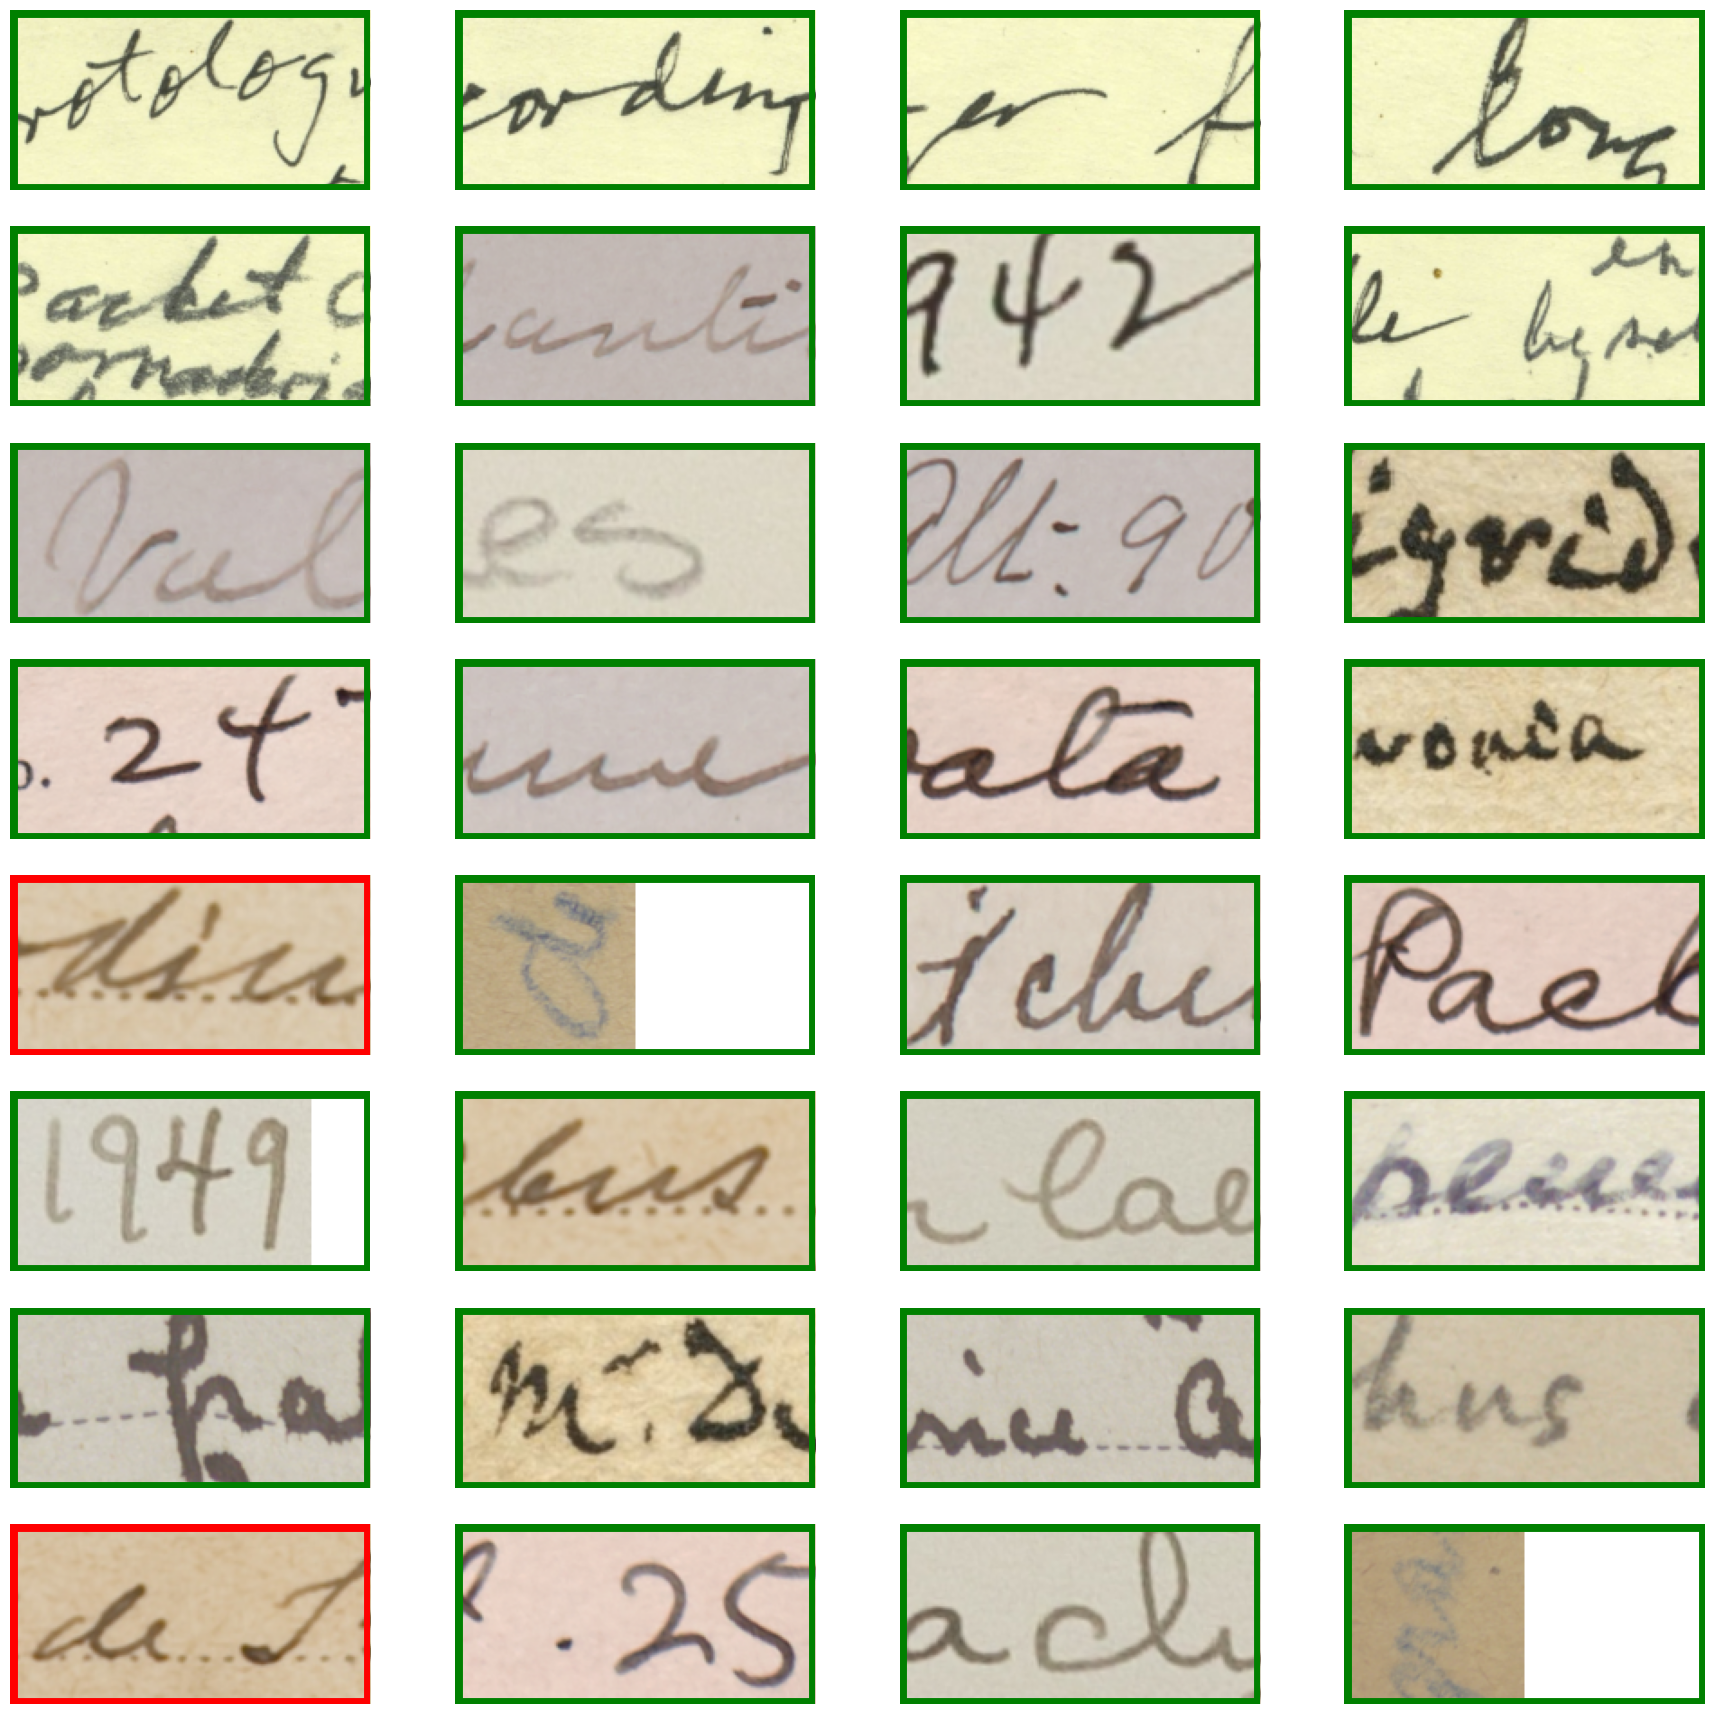

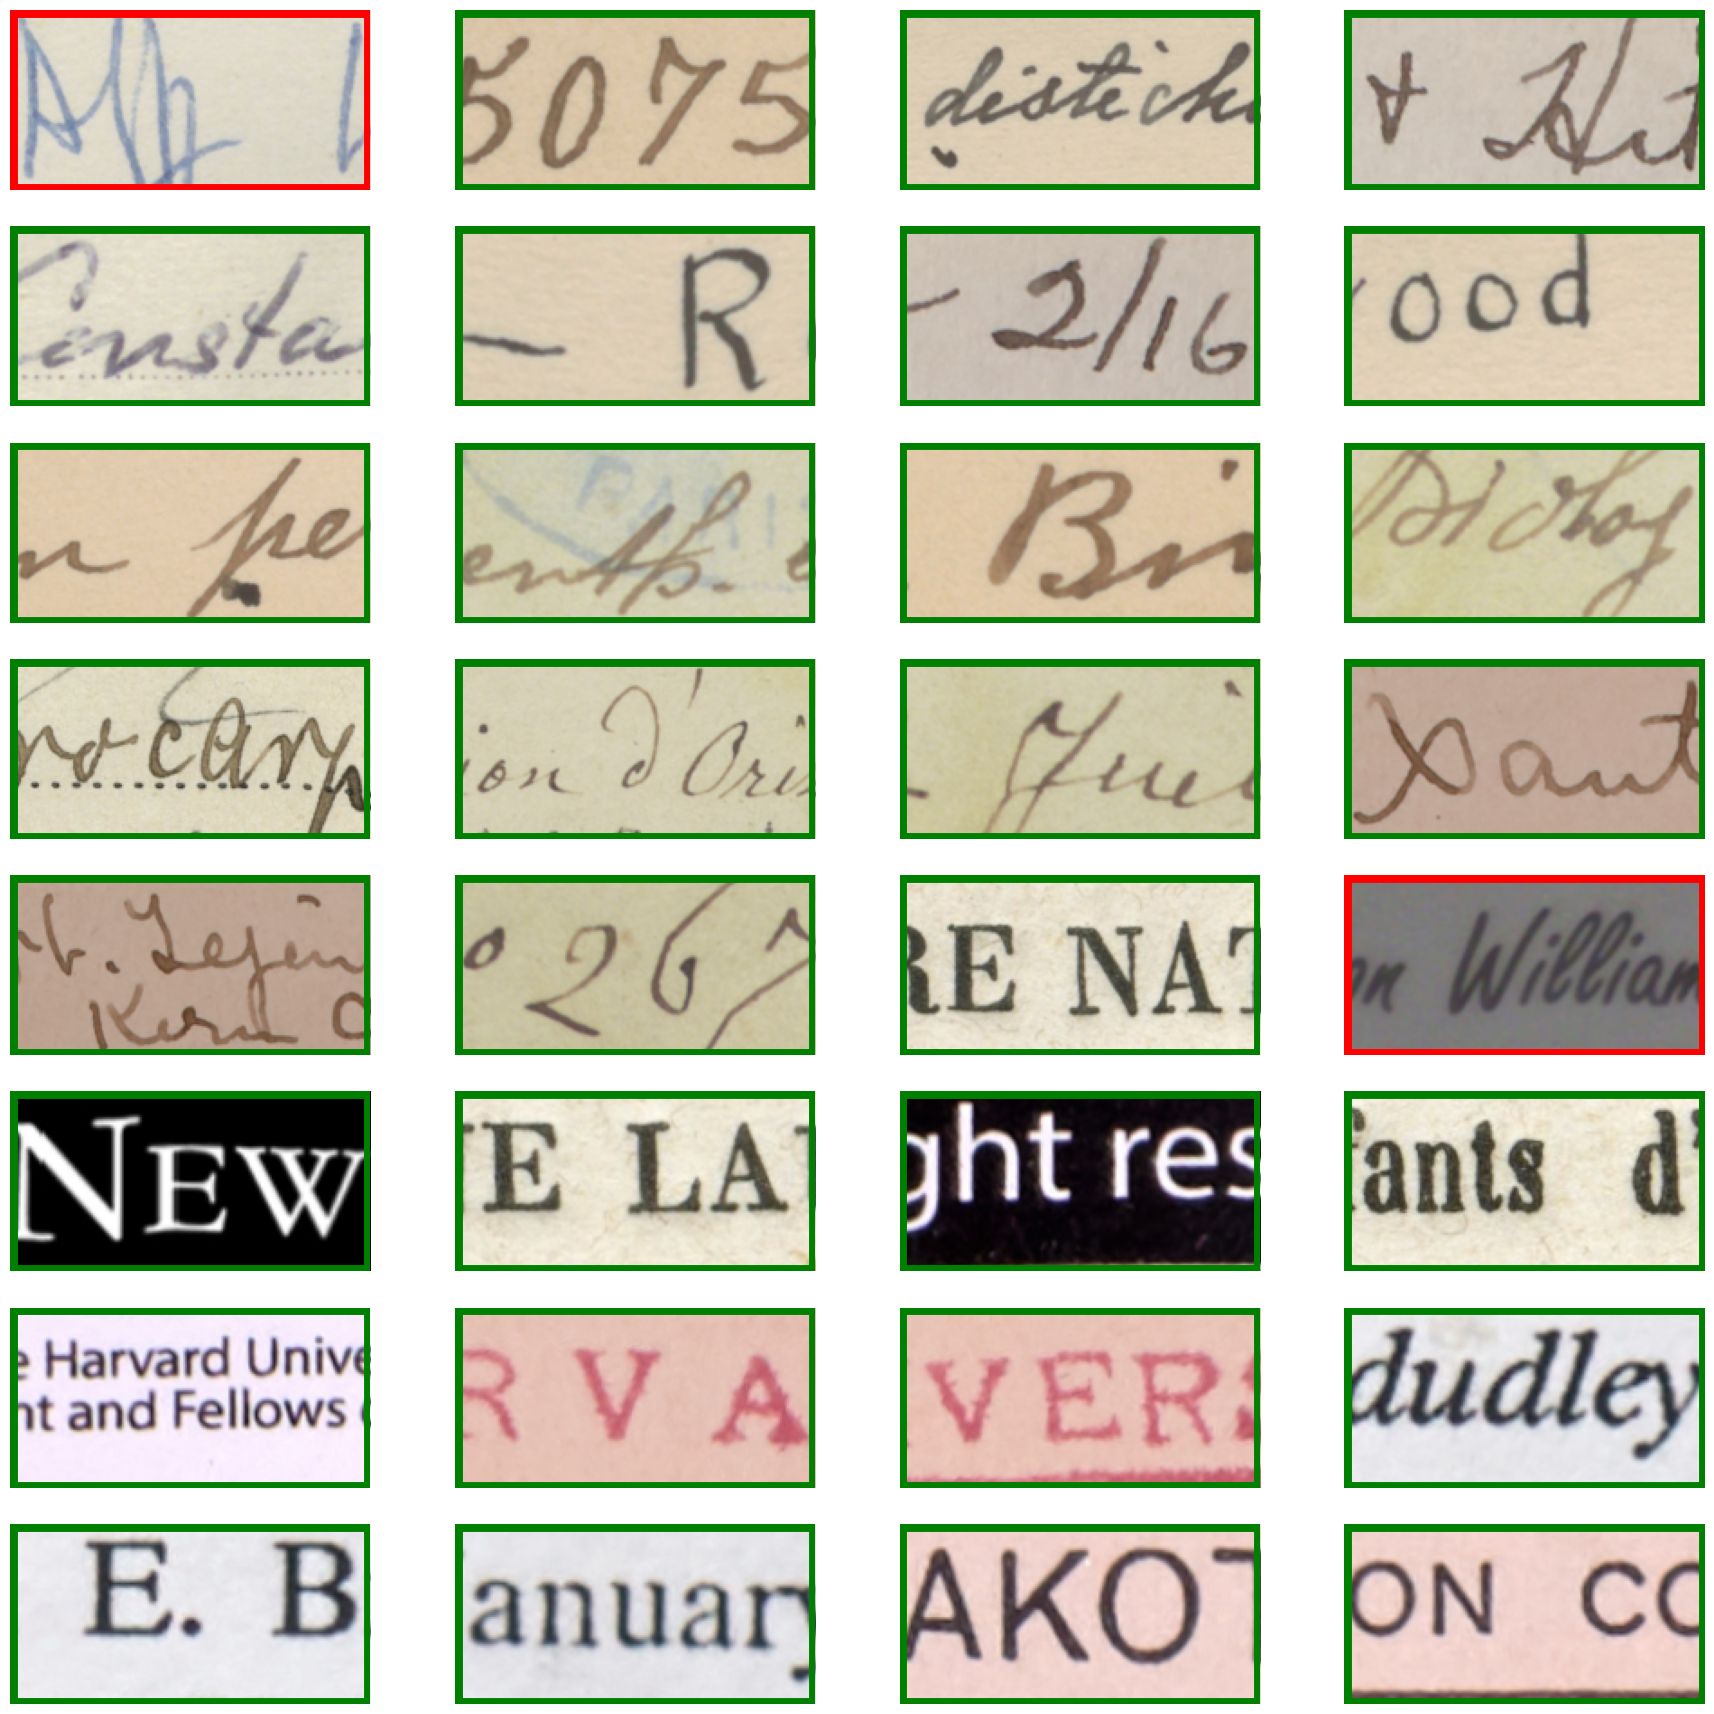

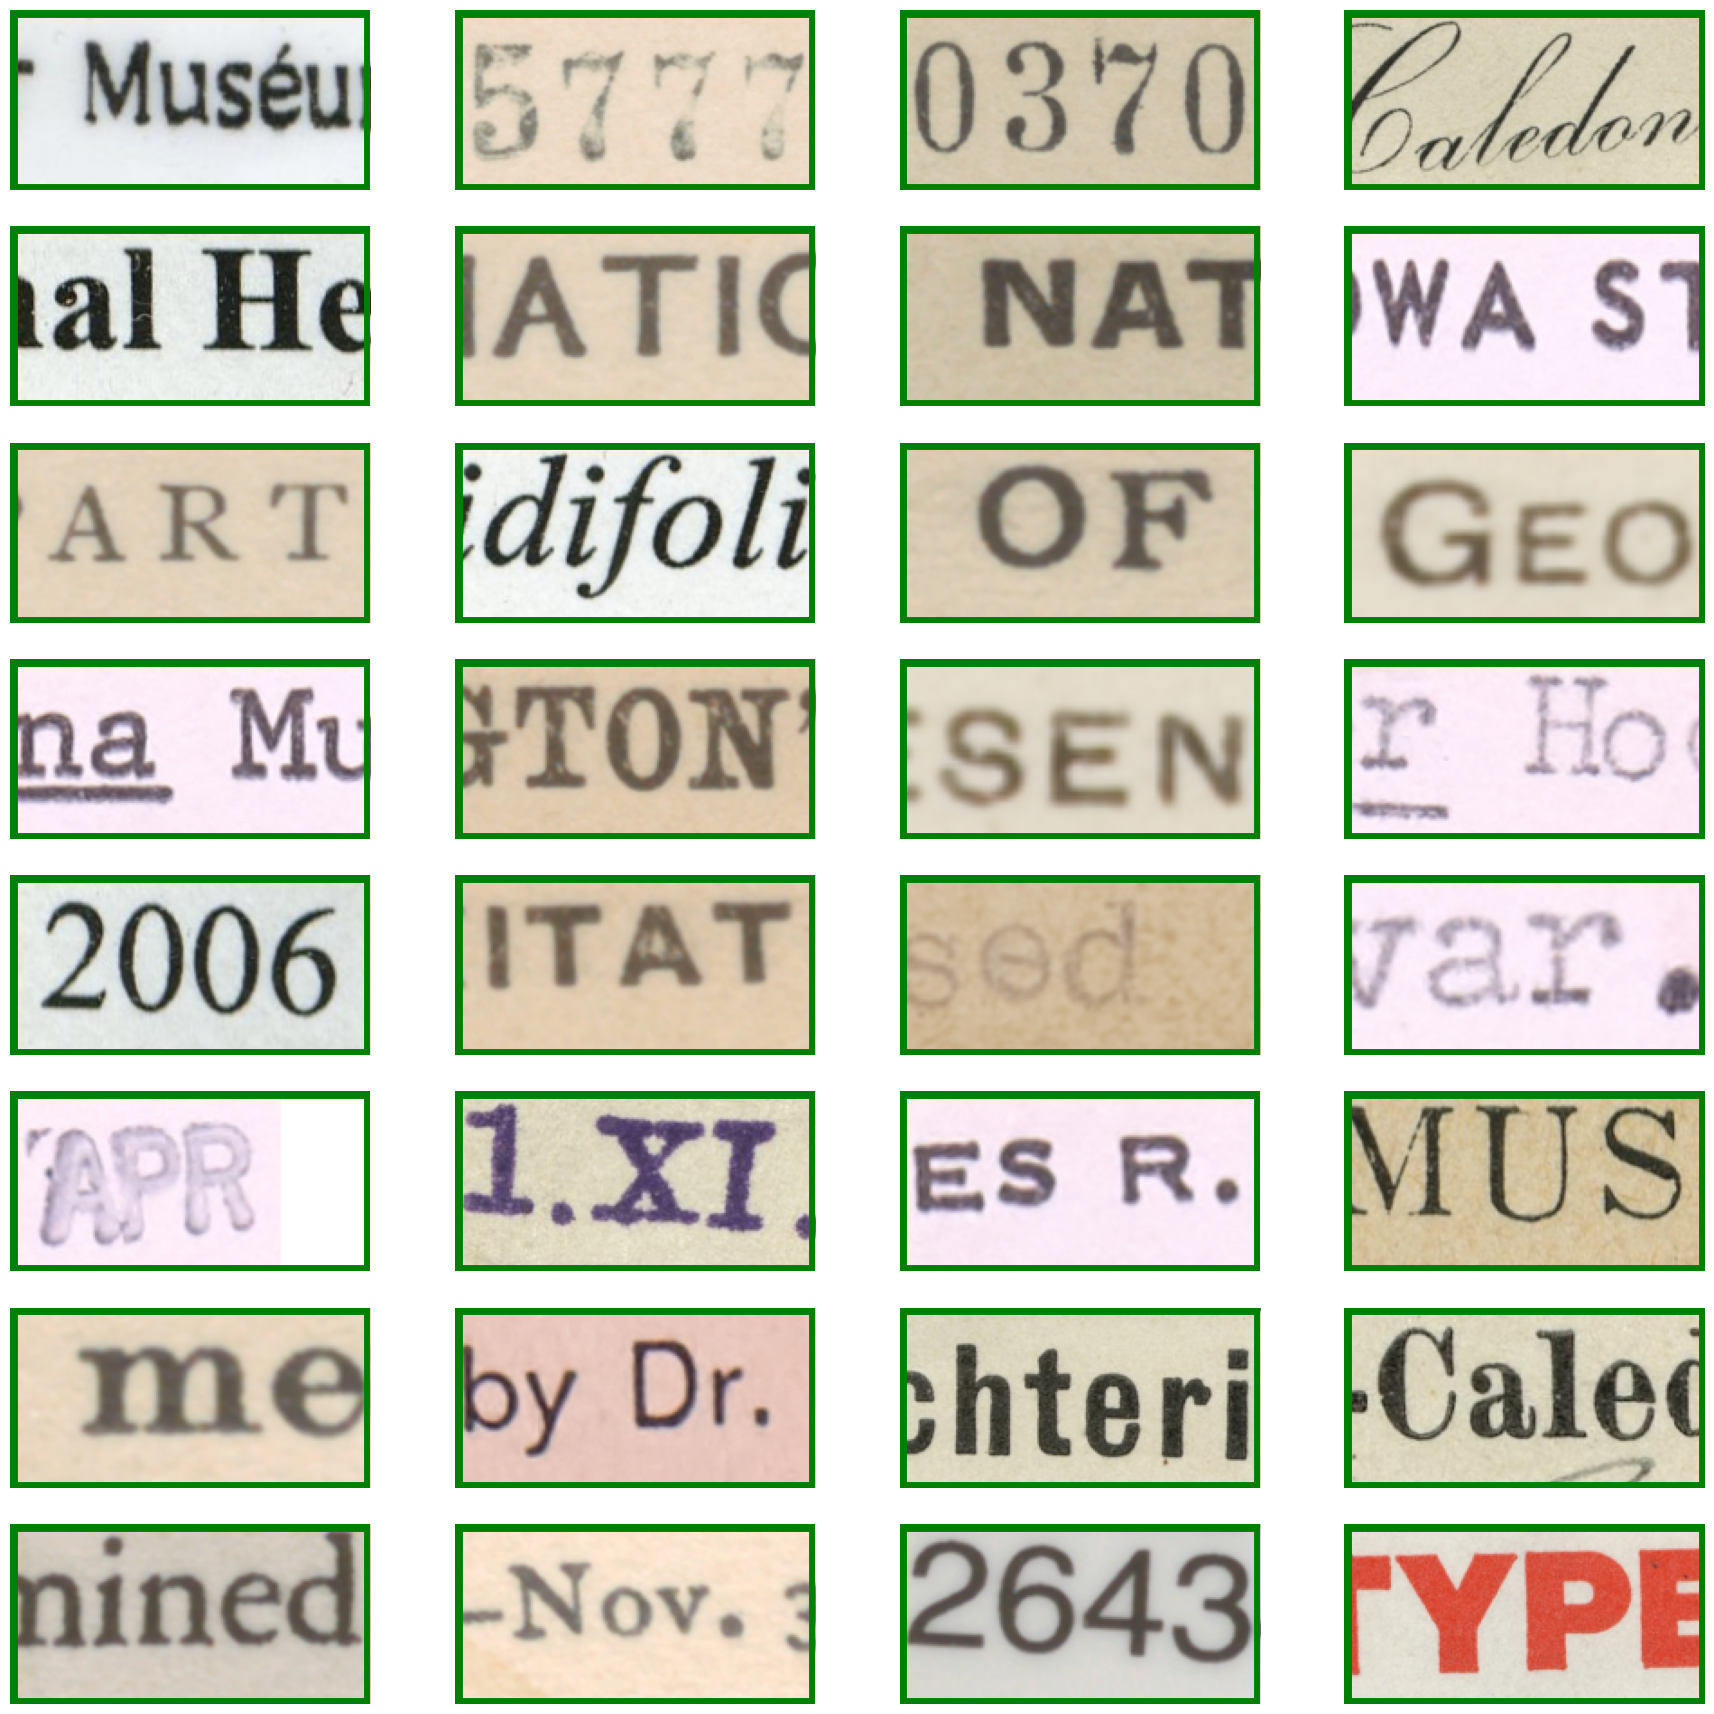

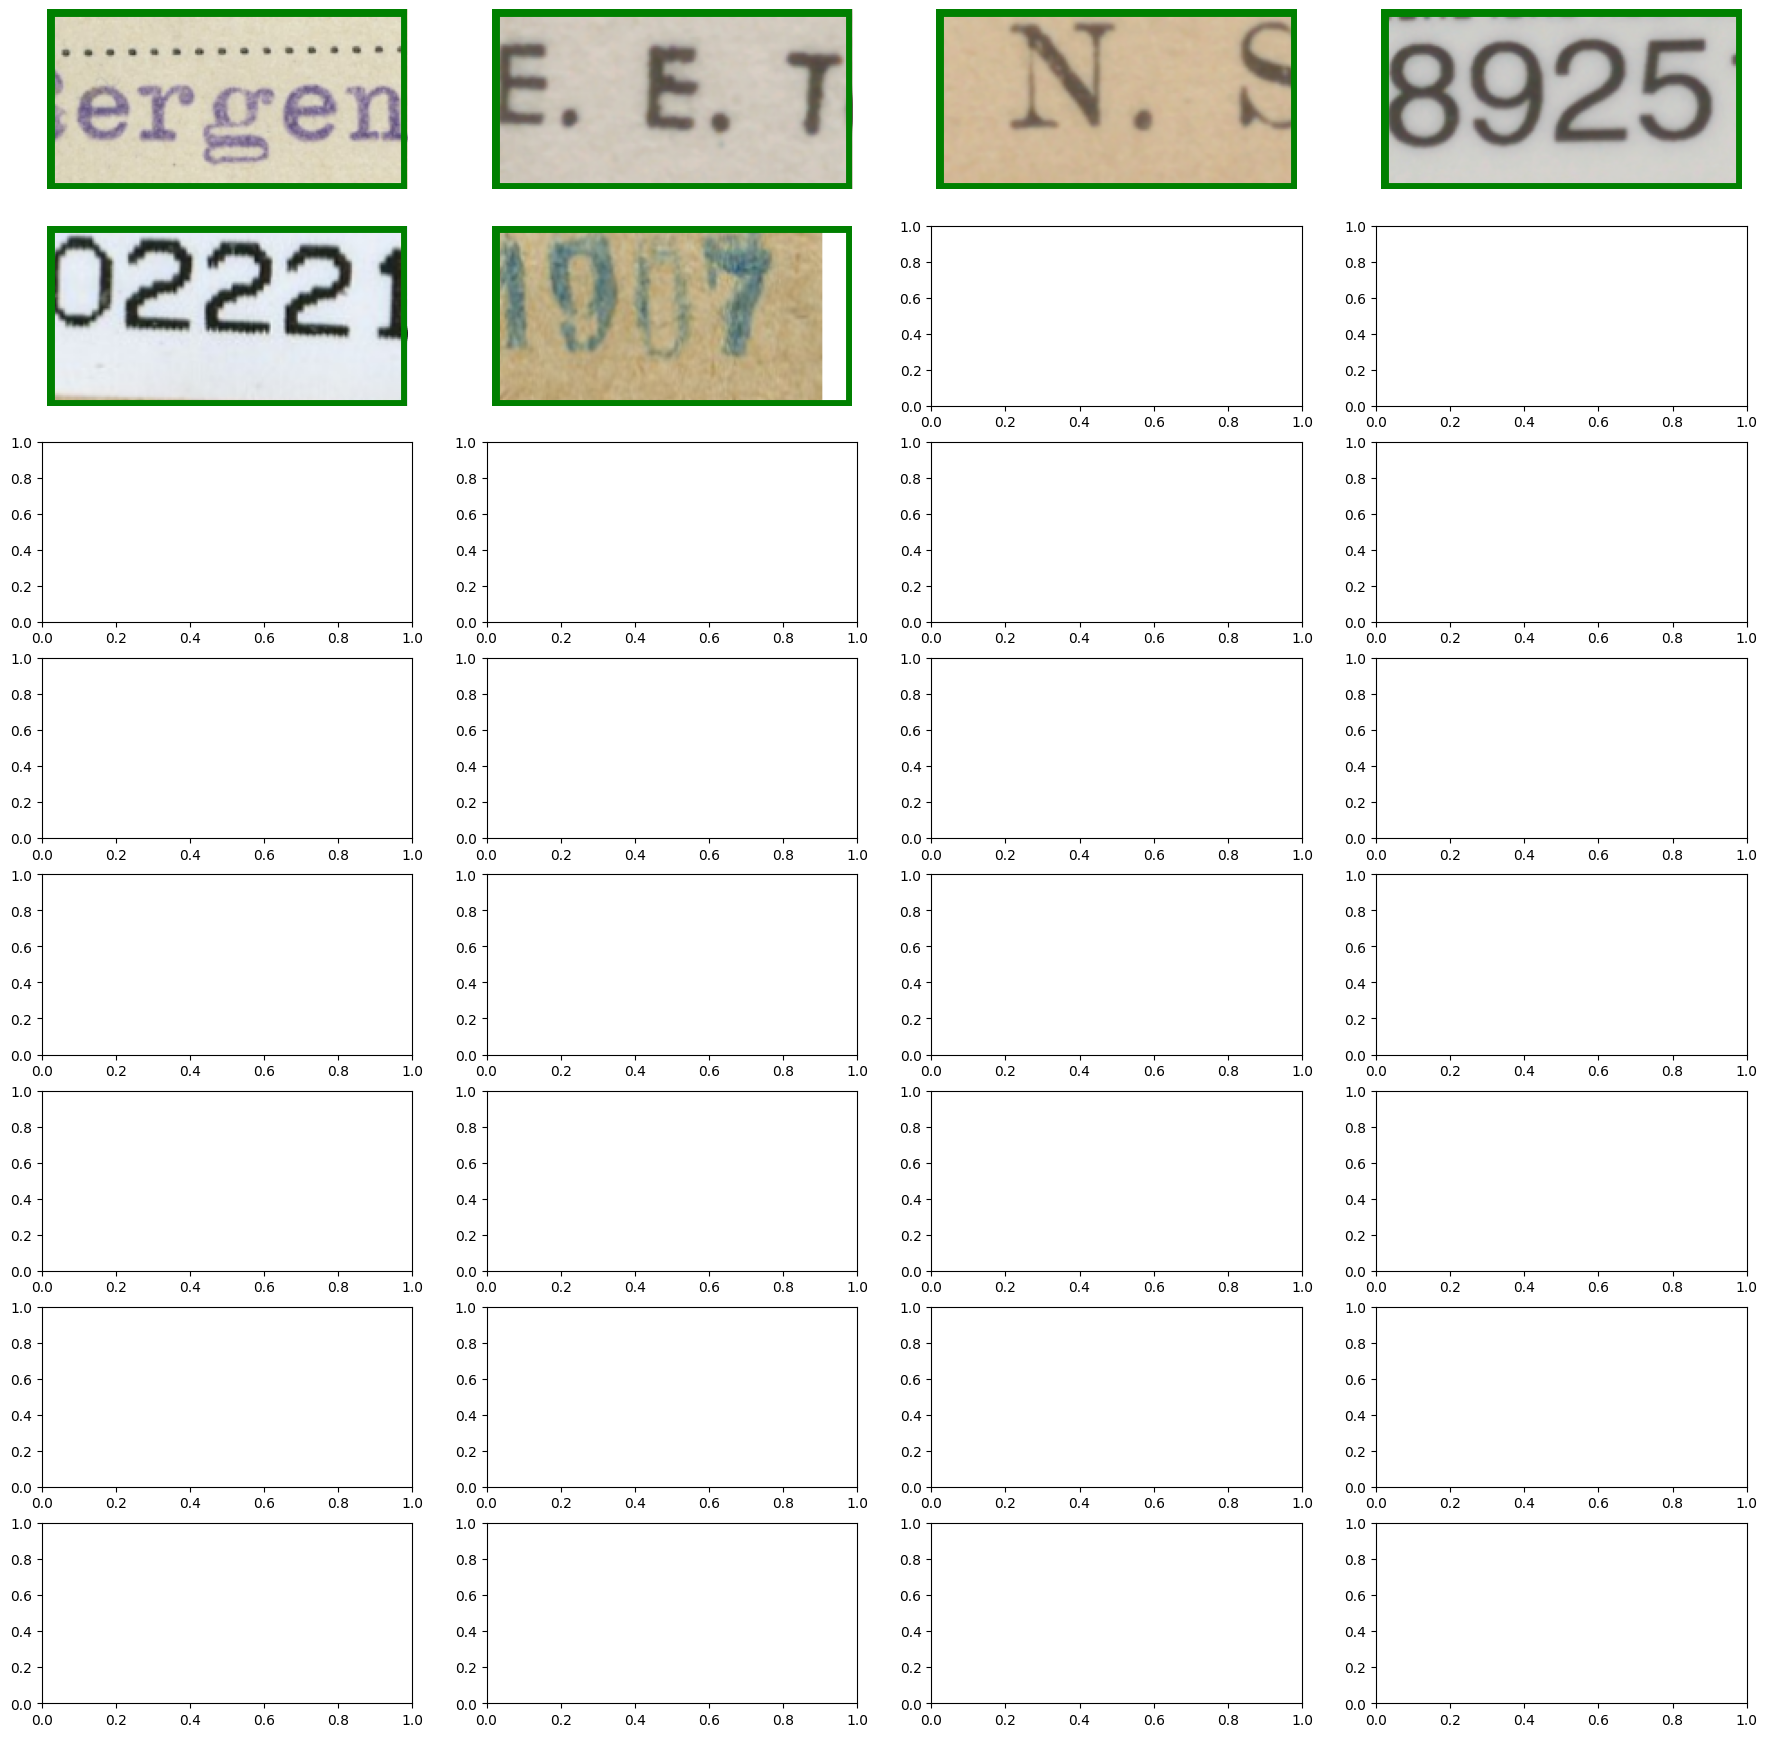

In [65]:
import warnings

test_dataset = ImageFolder(test_data_path, transform=test_preprocess)
test_loader = DataLoader(test_dataset, batch_size=32)

# Disable the warning
warnings.filterwarnings("ignore", category=UserWarning)

img_no = 0

# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
        
    num_rows = 8

    # Plot the images
    fig, axes = plt.subplots(num_rows, 4, figsize=(22, 22))
    for i in range(num_rows):
        for j in range(4):
            try:
                axes[i][j].imshow(images[img_no%32])
                axes[i][j].axis('off')
            except IndexError:
                break
            
            edge_color = 'g'
            
            if img_no == len(test_loader.dataset):
                break_flag = True
                break
            if(y_true_cpu[img_no] != y_pred_cpu[img_no]):
                edge_color = 'r'
            
            
            # Create a Rectangle patch
            rect = patches.Rectangle((0, 0), 200, 100, linewidth=10, edgecolor=edge_color, facecolor='none')
            axes[i][j].add_patch(rect)
            img_no += 1
    plt.show()

## Experiments

In [ ]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification

# # Instantiate feature extractor and model
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# # Adjust the classifier to match the number of classes
# num_classes = 2  # Assuming you have two classes: handwritten or machine typed
# model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)

# model = model.to(device)

# # Now you can use this model in your training loop
# for epoch in range(10):  # Adjust as needed
#     for images, labels in train_loader:
        
#         print(inputs)

#         inputs = feature_extractor(images=images, return_tensors="pt")
        
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         print(inputs)
#         outputs = model(**inputs)

#         loss = loss_function(outputs.logits, labels)
        
#         train_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     print(f'Train loss at epoch {epoch+1}: {train_loss.item()}')

In [26]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# load image from the IAM dataset
# url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
# image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image = Image.open("data/all_preprocessed_data/typed/FUNSD0000971160-10.jpg").convert("RGB")
# image = Image.open("data/all_preprocessed_data/typed/syntheticfile-9_crops-000152.jpg").convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'ii'

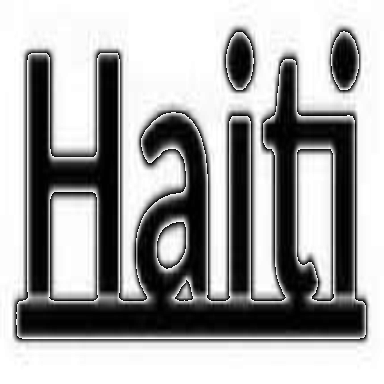

In [21]:
temp_image = transforms.ToPILImage()(pixel_values[0])
temp_image

In [33]:
generated_ids

tensor([[   2, 4132,    2]])

In [11]:
# The `encoder_outputs` variable will contain the intermediate output 
# of the vision transformer part of the TrOCR model
encoder_outputs = model.encoder(pixel_values)

# This is the image representation
image_representation = encoder_outputs.last_hidden_state
image_representation = image_representation.mean(dim=1)  # shape will now be [1, 768]

In [12]:
image_representation

tensor([[ 0.1725, -0.3867, -0.1286,  ...,  0.2052, -0.3625, -0.4994],
        [-0.0924, -0.2957, -0.2853,  ...,  0.6164, -0.2388, -0.2822],
        [ 0.1588, -0.3444, -0.2023,  ...,  0.5765, -0.0988, -0.1870],
        ...,
        [-0.0030, -0.6578,  0.2199,  ...,  0.3897, -0.0497, -0.4029],
        [-0.2889, -0.2004,  0.1602,  ...,  0.5631, -0.2646, -0.0362],
        [ 0.3208, -0.3533,  0.1339,  ...,  0.7275,  0.0027, -0.3574]],
       device='cuda:0')

In [13]:
image_representation.shape

torch.Size([32, 768])